<a id="overview"></a>
# Overview
---

On this project, I will work through a forecasting project, from loading the dataset and defining the problem to traning a final model and making predictions.

The steps of this project that we will through are as follows.<br>
<br>   1. [Business and Problem Understanding](#problem)
<br>   2. [Data Understanding](#data)
<br>   3. [Data Preparation](#dataprep)
<br>   4. [Modelling](#model)
<br>   6. [Evaluation](#evaluation)
<br>   7. [Summary](#summary)

This will be my template for working a time series prediction problem that I will use on my dataset.

For the additional research, I made some [Sentiment Analysis](#sentiment) for the client.

<a id="problem"></a>
# 1. Business and Problem Understanding
---

### About the Client

The client is a Business student that have plans to open a Hairdressing Salon at Sydenham. Sydenham has a mixture of residential and industrial developments. A very small group of shops is located around the intersection of Unwins Bridge Road and Railway Road, close to Sydenham railway station. In the 2016 Census, there were 1,145 people in Sydenham. 51.9% of people were born in Australia and 51.0% of people only spoke English at home.

### Problem Statement

The client did some researches on his Business plan and approached me as a Data Scientist can predict the population of the target customers at Sydenham, Marrickville, Tempe and St Peters on the next few years.

The dataset given provides the number of population of the target customers (Male Age 60+, Female Age 60+,  Professionals, Managers, Community and Personal Service Workers, Clerical and Administrative workers and Sales Workers) from 2006, 2011 and 2016.


<a id="data"></a>[Top](#overview)
# 2. Data Understanding
---

The dataset is credited to [Census from Australia Bureau of Statistics](http://www.abs.gov.au/websitedbs/D3310114.nsf/Home/Census?OpenDocument&ref=topBar)
. For us to predict next year we need the data to have yearly observations. From 2006 to 2016 observations will be used to validate the final model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [2]:
#Load the data and set the Year as the index and as date datatypes
df = pd.read_csv('Census_Data.csv',index_col='Year',parse_dates=['Year'])
df.dropna(inplace=True)
df.head()

,Location,Male_age_60+,Female_age_60+,Professionals,Managers,Community_and personal_service_workers,Clerical_and_administrative_workers,Sales_Workers,Total
Year,,,,,,,,,
2016-01-01,Sydenham,162,206,162,86,73,75,62,826
2016-01-01,Marrickville,3780,4423,4769,1855,1320,1791,1078,19016
2016-01-01,St Peters,336,298,727,329,173,295,143,2301
2016-01-01,Tempe,570,575,514,273,158,291,137,2518
2011-01-01,Sydenham,125,138,128,69,56,91,56,663


In [3]:
%%HTML

<div class='tableauPlaceholder' id='viz1516712466188' style='position: relative'><noscript><a href='#'><img alt='Target Customer&#39;s Population ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;TC&#47;TCP&#47;Sheet1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='TCP&#47;Sheet1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;TC&#47;TCP&#47;Sheet1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1516712466188');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

The dataset is not current and with gaps of 5 years. This means that we need to fill in data to validate the model. As the year column is integer I changed it to date datatypes and set it as the index.

In [4]:
df.shape

(12, 9)

There are 12 observations only and 9 columns which indicates the clients target types of customer. Mrrickville have a high number of Professionals in 2016

<a id="dataprep"></a>[Top](#overview)
# 3. Data Preparation
---

For us to predict the next years of target customer's population we only need the total of it and left only Years, Locations and Total Target.

In [5]:
#drop the column Total
df.drop('Total', axis=1,inplace=True)
#make a new Total column
df['Total_Target'] = df['Male_age_60+']+df['Female_age_60+']+df['Professionals'] + df['Managers'] + df['Community_and personal_service_workers'] + df['Clerical_and_administrative_workers'] + df['Sales_Workers']

I will seperate the data per Location

In [6]:
#sydenham
sydenham = df[df.Location.values == 'Sydenham'].sort_index()
sydenham = sydenham[['Total_Target']]
#marrickville
marrickville = df[df.Location.values == 'Marrickville'].sort_index()
marrickville = marrickville[['Total_Target']]
#tempe
tempe = df[df.Location.values == 'Tempe'].sort_index()
tempe = tempe[['Total_Target']]
#stpeters
stpeters = df[df.Location.values == 'St Peters'].sort_index()
stpeters = stpeters[['Total_Target']]

In [7]:
sydenham

,Total_Target
Year,
2006-01-01,557
2011-01-01,663
2016-01-01,826


As you can see we only have 3 years and with 5 years gap. I will treated the gaps as missing data and interpolate those gaps.

In [8]:
#this will interpolate the gaps every 5 years and save as csv
def fill_gaps(data,file):
    dt = pd.date_range('01-01-2006','01-01-2016',freq='AS')
    idx = pd.DatetimeIndex(dt)
    data = data.reindex(idx)
    data = data.interpolate(method='time')
    data.index = data.index.year
    data.to_csv(file)
    return data

In [9]:
sydenham

,Total_Target
Year,
2006-01-01,557
2011-01-01,663
2016-01-01,826


In [10]:
sydenham = fill_gaps(sydenham,'Sydenham.csv')
sydenham

,Total_Target
2006,557.000000
2007,578.188390
2008,599.376780
2009,620.623220
2010,641.811610
2011,663.000000
2012,695.582147
2013,728.253560
2014,760.835706
2015,793.417853


In [11]:
marrickville = fill_gaps(marrickville,'Marrickville.csv')
tempe = fill_gaps(tempe,'Tempe.csv')
stpeters = fill_gaps(stpeters,'St Peters.csv')

<a id="model"></a>[Top](#overview)
# 4. Modelling
---

Im going to use Linear Regression as the data are linear. Load the dataset and split into two, one for model train and the other for test. This will be the baseline prediction method and performance, then start digging into the data.

In [12]:
#Linear Regression for split data
def linear_regression(dataset,a):
    X = dataset.iloc[:, :-1].values
    y = dataset.iloc[:, 1].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)
    
    regressor = LinearRegression()
    
    if a == 'train':
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        score = regressor.score(X_train, y_train)
        
        plt.scatter(X_train, y_train, color = 'red')
        plt.plot(X_train, regressor.predict(X_train), color = 'blue')
        plt.title('Census (Training set)')
        
    if a == 'test':
        regressor.fit(X_test, y_test)
        y_pred = regressor.predict(X_test)
        score = regressor.score(X_test, y_test)
        
        plt.scatter(X_test, y_test, color = 'red')
        plt.plot(X_test, regressor.predict(X_test), color = 'blue')
        plt.title('Census (Test set)')

    plt.xlabel('Years')
    plt.ylabel('Total Target')
    plt.show()
    return a + ' Reg. Score: '+ str(score)

### Predicting the split datas

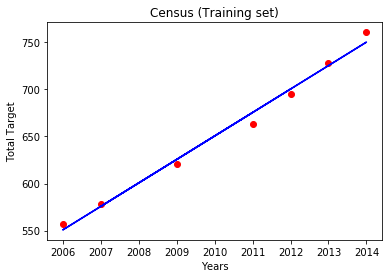

'train Reg. Score: 0.9894590712707553'

In [13]:
old_sydenham = pd.read_csv('Sydenham.csv')
linear_regression(old_sydenham,'train')

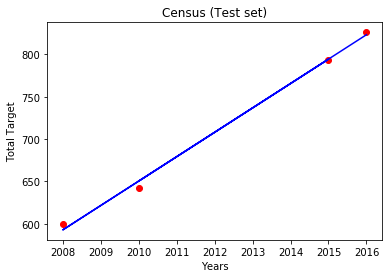

'test Reg. Score: 0.9966180252323654'

In [14]:
linear_regression(old_sydenham,'test')

Sydenham data has 98% score its so close to the baseline. Sydenham has always the lowest population compare to other areas although it rise but still lowest than the other area.

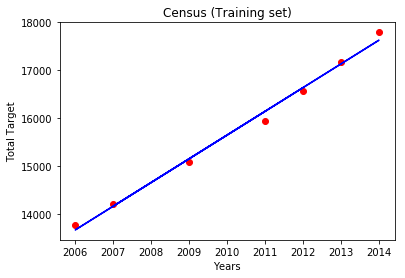

'train Reg. Score: 0.9932615027278053'

In [15]:
old_marrickville = pd.read_csv('Marrickville.csv')
linear_regression(old_marrickville,'train')

The Marrickville data is more closer to the baseline it has regressor of score 99% compare to Sydenham. Marrickville still way higher population than Marrickville but the flow of how the population rise almost same as Sydenham

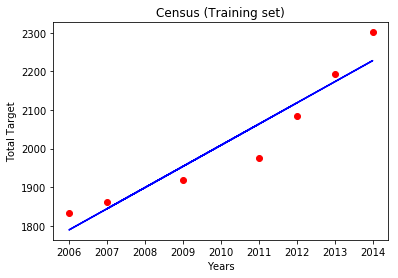

'train Reg. Score: 0.9019274677330884'

In [16]:
old_tempe = pd.read_csv('Tempe.csv')
linear_regression(old_tempe,'train')

In [17]:
old_tempe

,Unnamed: 0,Total_Target
0,2006,1834.000000
1,2007,1862.384447
2,2008,1890.768894
3,2009,1919.231106
4,2010,1947.615553
5,2011,1976.000000
6,2012,2084.340635
7,2013,2192.978094
8,2014,2301.318729
9,2015,2409.659365


Tempe has the lowest score compare to the other four areas. It has 90% score. Since 2011 to 2016 the population of target custumers risen by 542.

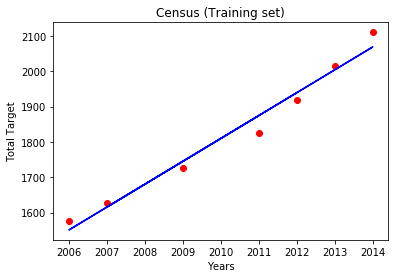

'train Reg. Score: 0.9755411819335427'

In [18]:
old_stpeters = pd.read_csv('St Peters.csv')
linear_regression(old_stpeters,'train')

St. Peters has 97% score and also close to the baseline but still higher compare to Sydenham.

### Predicting the next 10 years

As our scores are doing well we going to use this model to predict the next 10 years.

In [19]:
#Will create new dataframe for next years
def pred_yrs(dataset,ctr):
    years = []
    total = []

    X = dataset.iloc[:, :-1].values
    y = dataset.iloc[:, 1].values
    regressor = LinearRegression()
    regressor.fit(X, y)
    
    for ctr in range(1, ctr):
        year = 2016 + ctr
        years.append(year)
        y_pred = regressor.predict(year)
        total.append(y_pred)

    df_new = pd.DataFrame()
    df_new['Years'] = years
    df_new['Total'] = total
    return df_new

In [20]:
#will combine the old and new data
def combine_data(old, new,file):
    old = old.astype(int)
    df1 = old.values
    new.Total = new.Total.astype(int)
    df2 = new.values
    new_df = np.concatenate((df1,df2),axis=0)
    new_data = pd.DataFrame(new_df,columns=['Years','Total_Target'])
    new_data.to_csv(file)
    new_data.index = new_data.Years
    new_data.drop('Years',axis=1,inplace=True)
    new_data.plot(kind='bar')
    return new_data

In [21]:
#the next 10 years prediction
new_sydenham = pred_yrs(old_sydenham,10)
new_sydenham

,Years,Total
0,2017,[839.9713432241333]
1,2018,[866.8743054864099]
2,2019,[893.7772677486792]
3,2020,[920.6802300109557]
4,2021,[947.583192273225]
5,2022,[974.4861545354943]
6,2023,[1001.3891167977708]
7,2024,[1028.2920790600401]
8,2025,[1055.1950413223167]


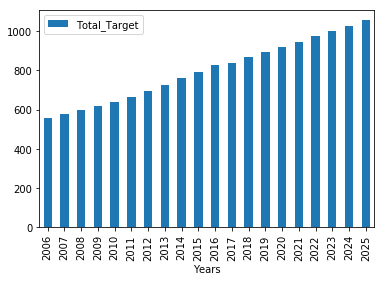

In [22]:
#combine the old data to next 10 years data
sydenham_new = combine_data(old_sydenham, new_sydenham,'Sydenham_new.csv')

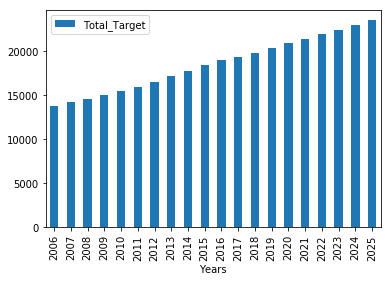

In [23]:
#the next 10 years prediction
new_marrickville = pred_yrs(old_marrickville,10)
#combine the old data to next 10 years data
marrickville_new = combine_data(old_marrickville, new_marrickville,'Marrickville_new.csv')

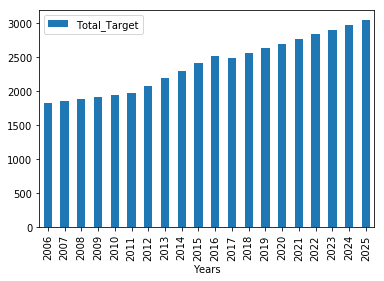

In [24]:
#the next 10 years prediction
new_tempe = pred_yrs(old_tempe,10)
#combine the old data to next 10 years data
tempe_new = combine_data(old_tempe, new_tempe,'Tempe_new.csv')

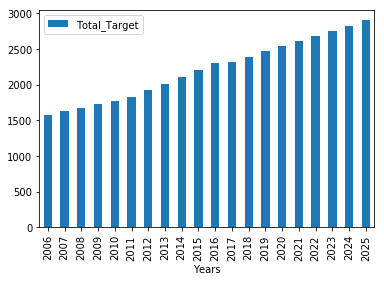

In [25]:
#the next 10 years prediction
new_stpeters = pred_yrs(old_stpeters,10)
#combine the old data to next 10 years data
stpeters_new = combine_data(old_stpeters, new_stpeters,'St Peters_new.csv')

<a id="evaluation"></a>[Top](#overview)
# 5. Evaluation
---

As we predicted the next 10 years of target customer's population, let's see what it will be the score if it improved.

In [26]:
sydenham_new = pd.read_csv('Sydenham_new.csv').drop('Unnamed: 0',axis=1)
sydenham_new.head()

,Years,Total_Target
0,2006,557
1,2007,578
2,2008,599
3,2009,620
4,2010,641


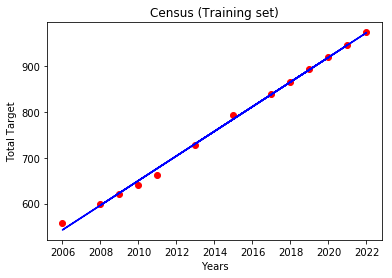

'train Reg. Score: 0.9976613240678391'

In [27]:
linear_regression(sydenham_new,'train')

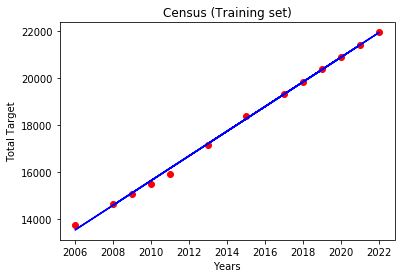

'train Reg. Score: 0.9984824323084335'

In [28]:
marrickville_new = pd.read_csv('Marrickville_new.csv').drop('Unnamed: 0',axis=1)
linear_regression(marrickville_new,'train')

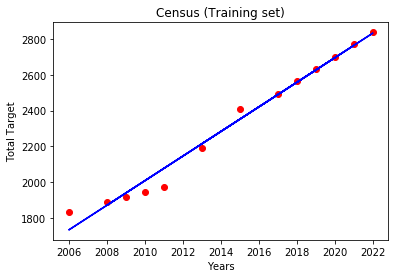

'train Reg. Score: 0.982707756894517'

In [29]:
tempe_new = pd.read_csv('Tempe_new.csv').drop('Unnamed: 0',axis=1)
linear_regression(tempe_new,'train')

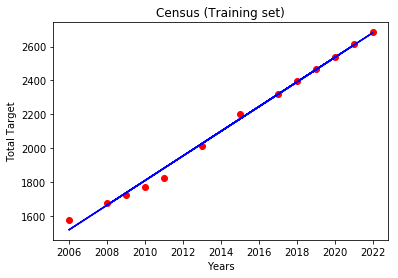

'train Reg. Score: 0.9949887206382461'

In [30]:
stpeters_new = pd.read_csv('St Peters_new.csv').drop('Unnamed: 0',axis=1)
linear_regression(stpeters_new,'train')

Only Tempe got 98% score as the rest are 99%. The models are all did a good job and as the score so high I think theres no other model will be better than this.

### Combine all Cities together

In [31]:
def fill_location(data, place):
    locations = []
    location = place

    for ctr in range(len(stpeters_new)):
        locations.append(location)

    data['Locations'] = locations

In [32]:
fill_location(sydenham_new, 'Sydenham')
fill_location(marrickville_new, 'Marrickville')
fill_location(tempe_new, 'Tempe')
fill_location(stpeters_new, 'St Peters')

In [33]:
stpeters_new.dtypes

Years            int64
Total_Target     int64
Locations       object
dtype: object

In [34]:
df1 = sydenham_new.values
df2 = marrickville_new.values
df3 = tempe_new.values
df4 = stpeters_new.values
new_df = np.concatenate((df1,df2,df3,df4),axis=0)
new_data = pd.DataFrame(new_df,columns=['Years','Total_Target','Locations'])

In [35]:
new_data.sort_values('Years').head()

,Years,Total_Target,Locations
0,2006,557,Sydenham
40,2006,1834,Tempe
20,2006,13770,Marrickville
60,2006,1576,St Peters
1,2007,578,Sydenham


In [36]:
new_data.index = new_data.Years
new_data.drop('Years',axis=1,inplace=True)

In [37]:
new_data.to_csv('New_data.csv')

In [38]:
%%HTML
<div class='tableauPlaceholder' id='viz1516761741858' style='position: relative'><noscript><a href='#'><img alt='Dashboard 1 ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Fi&#47;FinalPrediction&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='FinalPrediction&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Fi&#47;FinalPrediction&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1516761741858');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='1000px';vizElement.style.height='827px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

### Total Target per year

In [39]:
df = pd.read_csv('New_data.csv')
df.dropna(inplace=True)
df.head()

,Years,Total_Target,Locations
0,2006,557,Sydenham
1,2007,578,Sydenham
2,2008,599,Sydenham
3,2009,620,Sydenham
4,2010,641,Sydenham


In [40]:
totals = pd.DataFrame()

In [41]:
df.Years.unique()

array([2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025])

In [42]:
tot = []
yr = []
for i in df.Years.unique():
    tot.append(df[df.Years.values==i].Total_Target.values.sum())
    yr.append(i)

In [43]:
totals['Year'] = yr
totals['Totals'] = tot

In [46]:
totals

,Year,Totals
0,2006,17737
1,2007,18269
2,2008,18802
3,2009,19338
4,2010,19871
5,2011,20407
6,2012,21256
7,2013,22108
8,2014,22958
9,2015,23808


In [45]:
totals.to_csv('Total_Targets.csv')

<a id="summary"></a>[Top](#overview)
# 6. Summary  
--- 

<img src="totals.png">

Based on this prediction the target cities, mostly will continue growing their population on the next 10  years based on this 99% accuracy of the model. Male & Female aged 60+ have a greater number on this cities, so a marketing strategies that will be benefit them will be a boost.

Linear Regression was used in this model although I tried to used Decision Trees and ARIMA but it doesn't worked as the data too small. 

I decided to make an Sentimental Analysis for additional research that will help the client on his decision making.

<a id="sentiment"></a>[Top](#overview)
# Sentiment Analysis  
--- 

I scraped Google Reviews from all of the salons near Sydenham. For the scraping code it is included here as [googleReviewsScraper.py](googleReviewsScraper.py).

Based on the reviews I gathered heres are the following I came up with:<br>
<br>    [Reviewer's Most Talkabout](#rmt)
<br>    [Positive & Negative Reviews](#posneg)
<br>    [Visualisation](#vis)
<br>    [Topics Modelling](#topic)
<br>    [Summary](#sum)

### Data Understanding

Here are the data gathered for scraping Google Reviews from salons near Sydenham.

In [48]:
df = pd.read_csv('Reviews.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)
df.head()

,Salon_Names,Address,Distance,Websites,Ratings,Schedules,Reviews,Reviewers_Rate
0,Memphis and Co.,"100C Sydenham Rd, Marrickville NSW 2204",5.8 km,http://www.memphisandco.com.au/,5.0,Monday Closed\nTuesday 10am–7pm\nWednesday 10a...,Tony is a great hairdresser. He's friendly and...,"Rated 5.0 out of 5,"
1,Memphis and Co.,"100C Sydenham Rd, Marrickville NSW 2204",5.8 km,http://www.memphisandco.com.au/,5.0,Monday Closed\nTuesday 10am–7pm\nWednesday 10a...,The best men’s salon in town. Come for the sty...,"Rated 5.0 out of 5,"
2,Memphis and Co.,"100C Sydenham Rd, Marrickville NSW 2204",5.8 km,http://www.memphisandco.com.au/,5.0,Monday Closed\nTuesday 10am–7pm\nWednesday 10a...,Dom is the man. He cuts your hair the way you ...,"Rated 5.0 out of 5,"
3,Memphis and Co.,"100C Sydenham Rd, Marrickville NSW 2204",5.8 km,http://www.memphisandco.com.au/,5.0,Monday Closed\nTuesday 10am–7pm\nWednesday 10a...,I have been a loyal customer here for the past...,"Rated 5.0 out of 5,"
4,Memphis and Co.,"100C Sydenham Rd, Marrickville NSW 2204",5.8 km,http://www.memphisandco.com.au/,5.0,Monday Closed\nTuesday 10am–7pm\nWednesday 10a...,Amazing hair parlour with a great stylist insi...,"Rated 5.0 out of 5,"


In [49]:
df.shape

(413, 8)

<a id="rmt"></a>[Top](#sentiment)
## Reviewer's Most Talkabout

I want to see whats most reviewer's talk about by including only Reviews and used NLP(Natural Language Processing) to count the frequency of each words.

In [50]:
from gensim.corpora.dictionary import Dictionary
from nltk.tokenize import word_tokenize

In [52]:
#I put only Reviews in a txt file and load it
f = open('Reviews.txt','r')
my_documents= f

In [53]:
#creating tokens from the reviews
tokenized_docs = [word_tokenize(doc.lower()) for doc in my_documents]
#creating dictionary
dictionary = Dictionary(tokenized_docs)
#creating corpus
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

In [54]:
#sorting corpus
docs = sorted(corpus[0], key=lambda w: w[1], reverse=True)

In [56]:
#create dataframe to store the results
wid = []
wctr = []
for word_id, word_count in docs[:150]:
    wid.append(dictionary.get(word_id))
    wctr.append(word_count)
    
word_count = pd.DataFrame()
word_count['Words']=wid
word_count['Counter']=wctr
word_count.head()

,Words,Counter
0,hair,140
1,great,109
2,service,98
3,place,82
4,cut,77


In [57]:
#save it
word_count.to_csv('WordCounts.csv',index=False)

<a id="posneg"></a>[Top](#sentiment)
## Positive & Negative Reviews

Here I want to see if a reviews are positive and negatives reviews based on NLP Vader results.

In [58]:
#loading and droping no reviews
dataset = pd.read_csv('Reviews.csv')
data = dataset['Reviews']
data = data[data != 'No Reviews']
data = data[data != 'No Review']

In [59]:
#importing Vader library
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [60]:
reviews = data.values

In [62]:
#download vader_lexicon if not available
#nltk.download('vader_lexicon')

results=[]
sentences = []
sid = SentimentIntensityAnalyzer()
for sentence in reviews:
    ss =  sid.polarity_scores(sentence)
    results.append(ss)
    sentences.append(sentence)

In [63]:
#create dataframe and save results of positive and negative reviews
df_results = pd.DataFrame()
pos = []
neg=[]

for res in results:
    neg.append(res['neg'])
    pos.append(res['pos'])
    
df_posneg = pd.DataFrame()
df_posneg['Reviews'] = reviews
df_posneg['Positive'] = pos
df_posneg['Negative'] = neg

In [65]:
df_posneg.head()

,Reviews,Positive,Negative
0,Tony is a great hairdresser. He's friendly and...,0.469,0.069
1,The best men’s salon in town. Come for the sty...,0.154,0.000
2,Dom is the man. He cuts your hair the way you ...,0.155,0.089
3,I have been a loyal customer here for the past...,0.169,0.073
4,Amazing hair parlour with a great stylist insi...,0.441,0.000


In [64]:
#save it
df_posneg.to_csv('PosNegReviews3.csv',index=False)

<a id="vis"></a>[Top](#sentiment)
### Visualisation 

With this visualisation the client can make up on some ideas on what mostly reviewers wants in a hairdressing salon.

In [66]:
%%HTML
<div class='tableauPlaceholder' id='viz1517798423005' style='position: relative'><noscript><a href='#'><img alt='Dashboard 1 ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;6P&#47;6PZ4WSTSD&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='path' value='shared&#47;6PZ4WSTSD' /> <param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;6P&#47;6PZ4WSTSD&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1517798423005');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='1000px';vizElement.style.height='827px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

 <a id="topic"></a>[Top](#sentiment)
## Topics Modelling

I decided to use LDA(Latent Dirichlet allocation) to look for those possible topics from the reviewers.

In [68]:
#loading gensim's lda
from gensim import corpora
from gensim.models.ldamodel import LdaModel

In [69]:
#loading reviews from txt file
with open('Reviews.txt') as f:
    documents = f.readlines()

In [70]:
#splitting all words into one array
for doc in documents:
    texts = doc.split(' ')

In [71]:
#create tokens
tokenized_docs = [word_tokenize(doc) for doc in texts]
len(tokenized_docs)

7368

In [72]:
#createdictionary
dictionary = corpora.Dictionary(tokenized_docs)
dicts = dictionary.token2id

In [73]:
#create corpus
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

In [ ]:
#create LDA model, this will takes time as we have more than 7k
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=20,passes= 10, eval_every=None)

In [ ]:
#save it
lda.save('lda.model')

In [74]:
#loading from the saved file will be quicker to load
lda = LdaModel.load('lda.model', mmap='r')

In [ ]:
#visualising
import pyLDAvis.gensim as gensimvis
import pyLDAvis
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.show(vis_data)


Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8891/    [Ctrl-C to exit]


127.0.0.1 - - [05/Feb/2018 13:54:34] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Feb/2018 13:54:35] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [05/Feb/2018 13:54:35] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [05/Feb/2018 13:54:35] "GET /LDAvis.js HTTP/1.1" 200 -
127.0.0.1 - - [05/Feb/2018 13:54:35] code 404, message Not Found
127.0.0.1 - - [05/Feb/2018 13:54:35] "GET /favicon.ico HTTP/1.1" 404 -


In [ ]:
pyLDAvis.display(vis_data)

<a id="sum"></a>[Top](#sentiment)
## Summary

<b>Mostly Talkabout</b>
        - the services are the most talkabout, so by making sure to have a good services from the salon will have a good boost for the business.
        
<b>Positive & Negative Reviews</b>
        - mostly of the positive and negative reviews are for the hairdresser's performance. We can say that having a really good hairdresser to your salon will have a huge impact on the business.
        
<b>Topic Modelling</b>
        - Topic 1 mostly about the services which is I am not surprise as customers always going to look up on hows the services, Topic 2 hair treatments is mostly mentioned, so having a good quality of hair treatments to be use in the salon is also a plus. Topic 3 nails was the topic so probably aside from having a haircut service on the salon add some extra services for nails like pedicure and manicure.